<a href="https://colab.research.google.com/github/Taeye-Kwack/Predict_illumination/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library & Data

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
fpath = '/content/drive/MyDrive/'
df=pd.read_csv(fpath + '0_light_input_report_0618_w_rain_final.csv')

# Data preprocessing

In [ ]:
df.columns=['date', 'CODE', 'y', 'temp', 'prcp', 'hum', 'sza', 'distance',
       'altitude', 'direction', 'windowsize(%)', 'blueness','gaussian_blue', 'building_shade'] # temp = temperature, hum = humidity, prcp = precipitation, sza = solar zenith angle

In [ ]:
df['date']=pd.to_datetime(df['date'])

## Drop columns not used

In [ ]:
df.drop('windowsize(%)',axis=1, inplace=True) # because all windowsizes are 100%

In [ ]:
df.drop('building_shade',axis=1,inplace=True) # because there are no shade by surrounding buildings 

## Drop NA

In [ ]:
df=df.dropna(axis=0)

## Check correlation

In [ ]:
cor=df.corr(method='pearson')
cor= cor.apply(lambda x: round(x ,2))
cor

,y,temp,prcp,hum,sza,distance,altitude,direction,blueness,gaussian_blue
y,1.00,0.31,-0.11,-0.28,0.02,-0.08,-0.07,0.31,-0.08,-0.14
temp,0.31,1.00,-0.42,-0.60,0.08,0.19,-0.04,0.40,0.05,0.09
prcp,-0.11,-0.42,1.00,0.67,0.06,-0.20,0.06,-0.09,0.20,0.22
hum,-0.28,-0.60,0.67,1.00,-0.18,-0.28,-0.00,-0.32,0.25,0.17
sza,0.02,0.08,0.06,-0.18,1.00,0.15,0.25,0.15,0.00,0.15
distance,-0.08,0.19,-0.20,-0.28,0.15,1.00,0.41,0.27,0.13,0.14
altitude,-0.07,-0.04,0.06,-0.00,0.25,0.41,1.00,0.11,0.04,0.01
direction,0.31,0.40,-0.09,-0.32,0.15,0.27,0.11,1.00,-0.27,-0.28
blueness,-0.08,0.05,0.20,0.25,0.00,0.13,0.04,-0.27,1.00,0.79
gaussian_blue,-0.14,0.09,0.22,0.17,0.15,0.14,0.01,-0.28,0.79,1.00


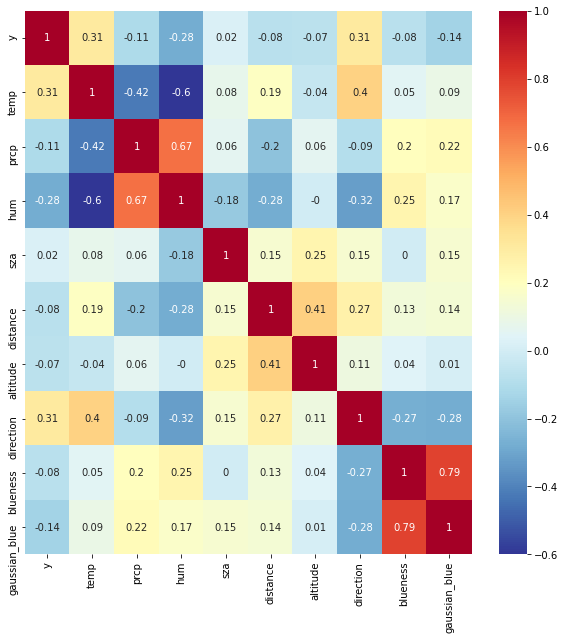

In [ ]:
import seaborn as sns
fig, ax = plt.subplots( figsize=(10,10) )
sns.heatmap(cor, cmap = 'RdYlBu_r', annot = True)  
plt.show()

In [ ]:
df = df.drop(['blueness'],axis=1) # we chose to use gaussian_blue instead of blueness to figure out the lightness of sky
df = df.drop(['hum'],axis=1) # because humidity's correlation with precipitation and temperature is so hight (the absolute value > 0.5)

cor=df.corr(method='pearson')
cor= cor.apply(lambda x: round(x ,2))
cor

,y,temp,prcp,sza,distance,altitude,direction,gaussian_blue
y,1.00,0.31,-0.11,0.02,-0.08,-0.07,0.31,-0.14
temp,0.31,1.00,-0.42,0.08,0.19,-0.04,0.40,0.09
prcp,-0.11,-0.42,1.00,0.06,-0.20,0.06,-0.09,0.22
sza,0.02,0.08,0.06,1.00,0.15,0.25,0.15,0.15
distance,-0.08,0.19,-0.20,0.15,1.00,0.41,0.27,0.14
altitude,-0.07,-0.04,0.06,0.25,0.41,1.00,0.11,0.01
direction,0.31,0.40,-0.09,0.15,0.27,0.11,1.00,-0.28
gaussian_blue,-0.14,0.09,0.22,0.15,0.14,0.01,-0.28,1.00


Text(0.5, 1.0, 'Correlation with natural light')

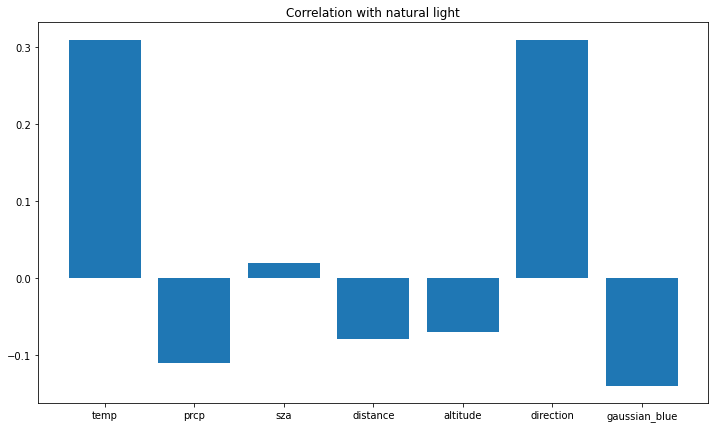

In [ ]:
columns = ['temp', 'prcp', 'sza', 'distance', 'altitude', 'direction', 'gaussian_blue']
fig, ax = plt.subplots(figsize=(12,7))
plt.bar(columns, cor.loc['y',columns])
plt.title('Correlation with natural light')

## Analysis without time series

In [ ]:
df['y'] =  preprocessing.scale(df['y']) 
df['temp'] = preprocessing.scale(df['temp'])
df['prcp'] = preprocessing.scale(df['prcp'])
df['sza'] = preprocessing.scale(df['sza'])
df['distance'] = preprocessing.scale(df['distance']) 
df['altitude'] = preprocessing.scale(df['altitude'])
df['direction'] = preprocessing.scale(df['direction'])
df['gaussian_blue'] = preprocessing.scale(df['gaussian_blue']) 

In [ ]:
train, test = train_test_split(df, test_size=0.3, shuffle=True, random_state=2021)
train_x = train[['temp', 'prcp', 'sza', 'distance', 'altitude', 'direction', 'gaussian_blue']]
train_y = train['y']

test_x = test[['temp', 'prcp', 'sza', 'distance', 'altitude', 'direction', 'gaussian_blue']]
test_y = test['y']

Text(0.5, 1.0, 'Distribution of y')

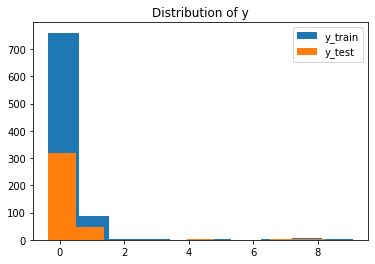

In [ ]:
plt.hist(train_y, label='y_train')
plt.hist(test_y, label='y_test')
plt.legend()
plt.title('Distribution of y')

## Linear Regression

RMSE : 0.9160645979779263
r_sq : 0.18075793730469858


Text(0, 0.5, 'y_predicted')

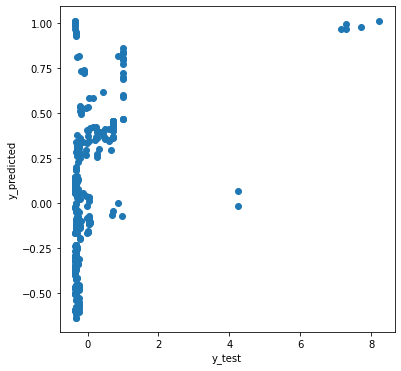

In [ ]:
model = LinearRegression()
model.fit(train_x, train_y)
y_predicted = model.predict(test_x)
rmse = np.sqrt(mean_squared_error(y_predicted, test_y))
print('RMSE :', rmse)
r_sq = model.score(test_x,test_y)
print('r_sq :', r_sq)
plt.figure(figsize=(6,6))
plt.scatter(test_y, y_predicted)
plt.xlabel('y_test')
plt.ylabel('y_predicted')

In [ ]:
features='temp+sza+distance+altitude+distance+direction+gaussian_blue'
y,x=dmatrices("y ~"+features,data=df,return_type='dataframe')
result=sm.OLS(y,x).fit()
print(result.summary()) # temp, distance, direction, gaussian_blue is statistically significant

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     43.95
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           7.80e-49
Time:                        02:44:59   Log-Likelihood:                -1636.5
No. Observations:                1238   AIC:                             3287.
Df Residuals:                    1231   BIC:                             3323.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.776e-17      0.026  -1.07e-15

## DecisionTree & Randomforest 

RMSE 0.36971173717107353
r_sq : 0.8665598506867824


Text(0, 0.5, 'y_predicted')

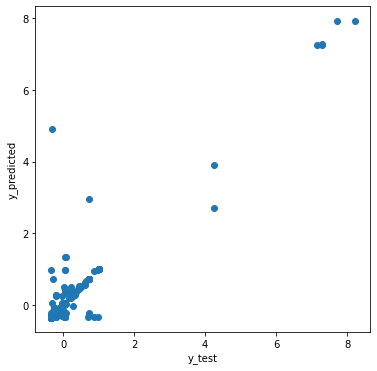

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model_d = DecisionTreeRegressor()
model_d.fit(train_x, train_y)
from sklearn.metrics import mean_squared_error
y_predicted = model_d.predict(test_x)
rmse = np.sqrt(mean_squared_error(y_predicted, test_y))
print('RMSE :', rmse)
r_sq = model_d.score(test_x,test_y)
print('r_sq :', r_sq)
plt.figure(figsize=(6,6))
plt.scatter(test_y, y_predicted)
plt.xlabel('y_test')
plt.ylabel('y_predicted')

RMSE 0.23789706427265364
r_sq : 0.9447492461221059


Text(0, 0.5, 'y_predicted')

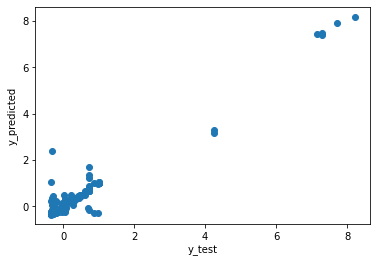

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_r = RandomForestRegressor()
model_r.fit(train_x, train_y)
y_predicted = model_r.predict(test_x)
rmse = np.sqrt(mean_squared_error(y_predicted, test_y))
print('RMSE', rmse)
r_sq = model_r.score(test_x,test_y)
print('r_sq :', r_sq)
plt.scatter(test_y, y_predicted)
plt.xlabel('y_test')
plt.ylabel('y_predicted')

<BarContainer object of 7 artists>

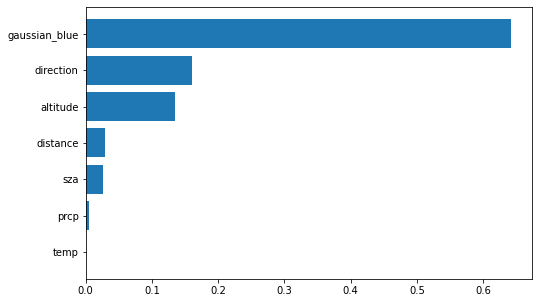

In [ ]:
columns = ['temp', 'prcp', 'sza', 'distance', 'altitude', 'direction', 'gaussian_blue']
importances = model_r.feature_importances_
forest_importances = pd.Series(importances, index=columns)
forest_importances = sorted(forest_importances)
plt.figure(figsize=(8,5))
plt.barh(columns,forest_importances)
# gaussian_blue >> direction, altutude >> distance, sza > prcp, temp

## xgboost

In [ ]:
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

[11:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
r_sq : 0.6596906248156764
RMSE : 0.5498099119281722


Text(0, 0.5, 'y_predicted')

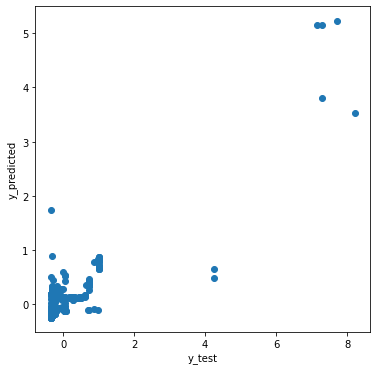

In [ ]:
XG_model = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.001, random_state=2021,colsample_bytree = 0.4,gamma = 0.05, max_depth= 4, min_child_weight= 1.1,subsample=0.8)
XG_model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=50,verbose=False)
r_sq = XG_model.score(train_x, train_y)
print('r_sq :', r_sq)
y_predicted = XG_model.predict(test_x)
rmse = np.sqrt(mean_squared_error(y_predicted, test_y))
print('RMSE :', rmse)
plt.figure(figsize=(6,6))
plt.scatter(test_y, y_predicted)
plt.xlabel('y_test')
plt.ylabel('y_predicted')

<Figure size 720x432 with 0 Axes>

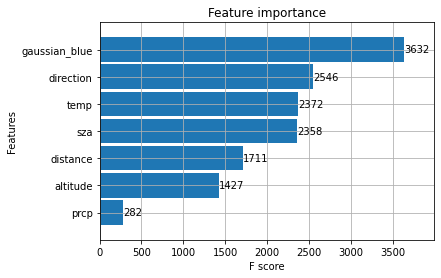

In [ ]:
# Feature importance
plt.figure(figsize=(10,6))
plot_importance(XG_model, height=0.9)
# Feature importance : gaussian_blue >> direction, temp, sza >> distance,altitude > prcp

In [ ]:
params = {'min_child_weight':[i/10.0 for i in range(5,18)], 'gamma':[i/100.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(4,9)], 'colsample_bytree':[i/10.0 for i in range(4,8)], 'max_depth': [2,3,4]}
xgb_reg = xgb.XGBRegressor(nthread=-1) 
grid = GridSearchCV(xgb_reg, params)
grid.fit(train_x, train_y)

In [ ]:
grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.04,
 'max_depth': 4,
 'min_child_weight': 1.1,
 'subsample': 0.4}

[11:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
r_sq : 0.6617179550229575
RMSE : 0.5886531228058972


Text(0, 0.5, 'y_predicted')

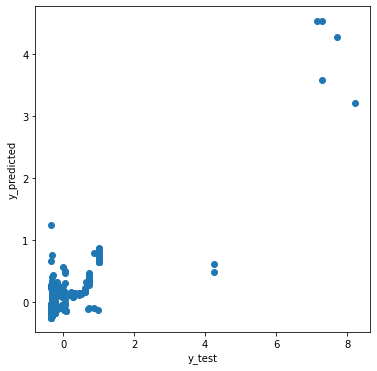

In [ ]:
XG_model = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.001, random_state=2021,colsample_bytree = 0.4,gamma = 0.04, max_depth= 4, min_child_weight= 1.1,subsample=0.4)
XG_model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=50,verbose=False)

r_sq = XG_model.score(test_x, test_y)
print('r_sq :', r_sq)
y_predicted = XG_model.predict(test_x)
rmse = np.sqrt(mean_squared_error(y_predicted, test_y))
print('RMSE :', rmse)
plt.figure(figsize=(6,6))
plt.scatter(test_y, y_predicted)
plt.xlabel('y_test')
plt.ylabel('y_predicted')

<Figure size 720x432 with 0 Axes>

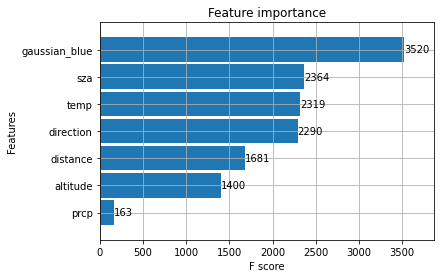

In [ ]:
# Feature importance
plt.figure(figsize=(10,6))
plot_importance(XG_model, height=0.9)

In [ ]:
<Result>
Linear Regression
RMSE : 0.9160645979779263
r_sq : 0.18075793730469858

DecisionTree
RMSE : 0.36915826638711025
r_sq : 0.8669590803285145

Randomforest
RMSE : 0.23789706427265364
r_sq : 0.9447492461221059
-> Feature importance : gaussian_blue >> direction, altutude >> distance, sza > prcp, temp
 
xgboost
r_sq : 0.6596906248156764
RMSE : 0.5498099119281722
-> Feature importance : gaussian_blue >> direction, temp, sza >> distance,altitude > prcp